## Initial preparations

In [299]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import functional as F

device = 'cuda' if torch.cuda else 'cpu'
device

'cuda'

## Dataset: Tiny Shakespeare

### Download

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [1]:
with open("input.txt", 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
print(len(text))

1115394


In [3]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



### Building vocabular

In [109]:
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print("".join(vocab))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### Tokenizing

Revise tokenisers:

- SentencePiece powered by Google
- TikToken

In [110]:
stoi = {ch:i for i,ch in enumerate(vocab)}
itos = {i:ch for i,ch in enumerate(vocab)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda L: [itos[i] for i in L]

print(encode("hello, world!"))
print(''.join(decode(encode("hello, world!"))))

[46, 43, 50, 50, 53, 6, 1, 61, 53, 56, 50, 42, 2]
hello, world!


In [111]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

### Train/Validation split

In [112]:
train_size = int(0.9*len(data))
train_X    = data[:train_size]
val_X      = data[train_size:]
print(train_size)

1003854


### Setup block_size - maximum context length

- context length - count of tokens in a continious line prior target token

In [113]:
block_size = 8
train_X[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [114]:
example_x = train_X[:block_size]
example_y = train_X[1:block_size+1]
for t in range(block_size):
    context = example_x[:t+1]
    target = example_y[t]
    print(f"when input is {context} the target is {target}")

when input is tensor([18]) the target is 47
when input is tensor([18, 47]) the target is 56
when input is tensor([18, 47, 56]) the target is 57
when input is tensor([18, 47, 56, 57]) the target is 58
when input is tensor([18, 47, 56, 57, 58]) the target is 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target is 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target is 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is 58


In [177]:
torch.manual_seed(1337)
batch_size = 4

def get_batch(split, batch_size=4):
    data = train_X if split == 'train' else val_X
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x  = torch.stack([data[i:i+block_size] for i in ix])
    y  = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


In [389]:
batch_size = 4
xb, yb = get_batch('train', batch_size)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)
print('----')
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[ 6,  0, 21, 44,  1, 61, 43,  1],
        [58, 52, 43, 57, 57,  2,  1, 57],
        [ 1, 59, 52, 39, 41, 46, 47, 52],
        [43, 42, 50, 39, 56,  6,  1, 50]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[ 0, 21, 44,  1, 61, 43,  1, 61],
        [52, 43, 57, 57,  2,  1, 57, 43],
        [59, 52, 39, 41, 46, 47, 52, 45],
        [42, 50, 39, 56,  6,  1, 50, 43]], device='cuda:0')
----
when input is [6] the target: 0
when input is [6, 0] the target: 21
when input is [6, 0, 21] the target: 44
when input is [6, 0, 21, 44] the target: 1
when input is [6, 0, 21, 44, 1] the target: 61
when input is [6, 0, 21, 44, 1, 61] the target: 43
when input is [6, 0, 21, 44, 1, 61, 43] the target: 1
when input is [6, 0, 21, 44, 1, 61, 43, 1] the target: 61
when input is [58] the target: 52
when input is [58, 52] the target: 43
when input is [58, 52, 43] the target: 57
when input is [58, 52, 43, 57] the target: 57
when input is [58, 52, 43, 57, 57] the target: 

### Baseline: Bigram Language Model

In [390]:
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dims=vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dims = embedding_dims
        self.tocken_embedding_table = nn.Embedding(vocab_size, embedding_dims)

    def forward(self, idx):
        return self.tocken_embedding_table(idx)

    def compute_loss(self, logits, targets):
        N, T, C = logits.shape
        return F.cross_entropy(logits.view(N*T, C), targets.view(N*T))

    def generate(self, initial_context, max_new_tokens):
        for _ in range(max_new_tokens):
            logits = self(initial_context)
            last_time_step_logits = logits[:,-1,:]
            probs = F.softmax(last_time_step_logits, dim=1)
            context_next = torch.multinomial(probs, num_samples=1)
            initial_context = torch.cat((initial_context, context_next), dim=1)
        return initial_context

    def generate_string(self, initial_context, max_new_tokens):
        return ''.join(
            decode(
                self.generate(initial_context, max_new_tokens=max_new_tokens)[0].tolist()
            )
        )


m = BigramLanguageModel(vocab_size).to(device)
logits = m(xb)
loss = m.compute_loss(logits, yb)
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.7051, device='cuda:0', grad_fn=<NllLossBackward0>)


In [391]:
-np.log(1/65)

4.174387269895637

In [392]:
initial_context = torch.zeros((1,1), dtype=torch.long, device=device)
print(m.generate_string(initial_context, max_new_tokens=100))


pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe


In [393]:
batch_size = 32
eval_iters = 200
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-2)
for steps in range(1000):
    xb, yb = get_batch("train")
    logits = m(xb)
    loss = m.compute_loss(logits, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

2.468719244003296


In [394]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(m.generate_string(context, max_new_tokens=500))


Wawice my.

TDER:
AnzCENup
Yow&$FMOUf is h bot m Whedill, ath iree s, hein lat HNGAd ov ts, and Wk p.
GSp.
Swanousel lind me l.
MAul, cechiry:
Supr aisspllw y.
Jllinke n Bfopetelaves;qke

Pl, d metSPkllo W-wou wh tCois 3s wouth dourivETENGShire s poo K:

PxTre

AL:

Inthrupt f s ar iris! m:

Thin maleronth, af Pre?d mySo myr KINLIE!
Ktidb&y, wardsal acesE:zLAnd din cNuk ay aney Iry ts I&fr af vNGJMOnEETonoke mary.
Yof 'soug me?m sora an hse.
Spond by we men.
Sand s st sulin s th llugivod, wimmuc


### Denoise loss calculation

In [395]:
class LossEstimator:
    
    def __init__(self, eval_step):
        self.eval_step = eval_step

    @torch.no_grad()
    def estimate_loss(self, model):
        estimations = dict()
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(self.eval_step)
            for k in range(self.eval_step):
                X, y = get_batch(split)
                logits = model(X)
                loss = model.compute_loss(logits, y)
                losses[k] = loss.item()
            estimations[split] = losses.mean().item()
        model.train()
        return estimations

### Collect all the training stuff into a single method

It includes:
- average loss estimations through batch of samples
- average losses for both train and valdidation split
- Adam optimizer with weights penalty
- learning_rate decay on plateau

In [396]:
def train(model, iterations, batch_size, optimizer, lr_scheduler, loss_estimator):
    loss_history = {"train": [], "val": []} 
    for i in range(iterations):
        if i % loss_estimator.eval_step == 0:
            losses = loss_estimator.estimate_loss(model)
            print(f"step {i} losses:", end=" ") 
            for split, loss_value in losses.items():
                loss_history[split].append(loss_value)
                print(f"{split} {losses['train']:.4f},", end=" ")
            lr_scheduler.step(losses['train'])
            print()
        xb, yb = get_batch('train', batch_size)
        logits = model(xb)
        loss = model.compute_loss(logits, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return loss_history


In [397]:
model = BigramLanguageModel(vocab_size).to(device)
iterations = 10000
batch_size = 32
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
loss_estimator = LossEstimator(eval_step=200)

In [398]:
initial_context = torch.zeros((1,1), dtype=torch.long, device=device)
print(model.generate_string(initial_context, max_new_tokens=100))


$ &!voyzUsSFuyzY;gl.VL
 EiaRkzJTl?l$iQTkXxsYVzXOPuAbTVH:lvMvLKJ?dCa?Cc
 NlPsh!fkpXvmMK&KJeV:PJDmdau$


In [399]:
loss_history = train(model, iterations, batch_size, optimizer, lr_scheduler, loss_estimator)

step 0 losses: train 4.5626, val 4.5626, 
step 200 losses: train 3.0365, val 3.0365, 
step 400 losses: train 2.6256, val 2.6256, 
step 600 losses: train 2.5434, val 2.5434, 
step 800 losses: train 2.4902, val 2.4902, 
step 1000 losses: train 2.4792, val 2.4792, 
step 1200 losses: train 2.5010, val 2.5010, 
step 1400 losses: train 2.4654, val 2.4654, 
step 1600 losses: train 2.4563, val 2.4563, 
step 1800 losses: train 2.4842, val 2.4842, 
step 2000 losses: train 2.4849, val 2.4849, 
step 2200 losses: train 2.4614, val 2.4614, 
step 2400 losses: train 2.4609, val 2.4609, 
step 2600 losses: train 2.4623, val 2.4623, 
step 2800 losses: train 2.4572, val 2.4572, 
step 3000 losses: train 2.4405, val 2.4405, 
step 3200 losses: train 2.4568, val 2.4568, 
step 3400 losses: train 2.4640, val 2.4640, 
step 3600 losses: train 2.4464, val 2.4464, 
step 3800 losses: train 2.4509, val 2.4509, 
step 4000 losses: train 2.4475, val 2.4475, 
step 4200 losses: train 2.4392, val 2.4392, 
step 4400 losses:

In [400]:
print(model.generate_string(initial_context, max_new_tokens=500))


Whe fe f tas ny, ct Clo gscest hes,
A: du he n, soxcone.

NENobeakes aghercobun ws m k s withoumas Fond t s wllo INour id, mersed
Fourd?
TI idurd po venond, d Cad ty
K:
BIUSoou tiund thornofen e sutan wiporthare whanot, sitthers, spe Bllellke, on s h O, t pan, ce wat d tive wout ir f; u;

Feknen oueee rtano iru forealoiroret HEnk;
CUCaden tck is, d cer t ftanofallon bay ho s, agallen, meseveminds s; te worimyoin ie--
ARUSThe Whou wowhedichea blare aned hy senInirstha theint de may, the an be ke 


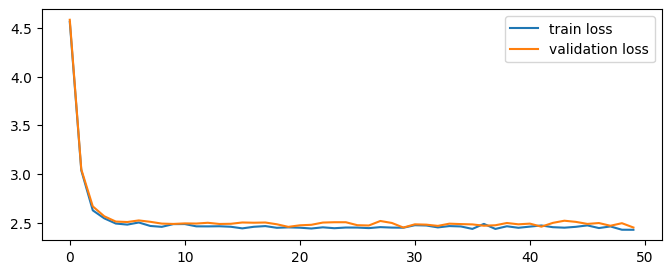

In [401]:
fig, ax_l = plt.subplots(1, 1, figsize=(8,3))
ax_l.plot(np.array(loss_history["train"]).flatten(), label = 'train loss')
ax_l.plot(np.array(loss_history["val"]).flatten(), label = 'validation loss')
ax_l.legend()

### Averaging past context by multiplication on triangle matrix

In [402]:
x = torch.randn(batch_size, block_size, vocab_size)
x.shape

torch.Size([32, 8, 65])

### straightforward implementation

In [403]:
%%timeit
xbow = torch.zeros((batch_size, block_size, vocab_size))
for b in range(batch_size):
    for t in range(block_size):
        xprev = x[b,:t+1]
        xbow[b,t] = torch.mean(xprev, 0)

4.29 ms ± 62.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Optimized implementation by matmul

In [404]:
%%timeit
wei = torch.tril(torch.ones((block_size, block_size)))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x

125 µs ± 5.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [405]:
torch.allclose(xbow, xbow2)

False

In [406]:
idx = torch.isclose(xbow, xbow2) == False
xbow[idx], xbow2[idx]

(tensor([ 0.0011, -0.0012,  0.0005, -0.0032,  0.0018,  0.0002, -0.0002, -0.0017]),
 tensor([ 0.0011, -0.0012,  0.0005, -0.0032,  0.0018,  0.0002, -0.0002, -0.0017]))

### Implementation with Softmax

In [407]:
%%timeit
tril = torch.tril(torch.ones((block_size, block_size)))
wei = torch \
    .zeros((block_size, block_size)) \
    .masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=1)
xbow3 = wei @ x

125 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [408]:
torch.allclose(xbow,xbow3)

False

In [409]:
idx = torch.isclose(xbow, xbow3) == False
xbow[idx], xbow3[idx]

(tensor([ 0.0011, -0.0012,  0.0005, -0.0032,  0.0018,  0.0002, -0.0002, -0.0017]),
 tensor([ 0.0011, -0.0012,  0.0005, -0.0032,  0.0018,  0.0002, -0.0002, -0.0017]))

### Bigram language model with Linear layer

In [422]:
class BigramLanguageModel2(BigramLanguageModel):
    def __init__(self, vocab_size, embedding_dims):
        super().__init__(vocab_size, embedding_dims)
        self.lm_head = nn.Linear(embedding_dims, vocab_size)

    def forward(self, idx):
        token_embeddings = super().forward(idx)
        return self.lm_head(token_embeddings)


embedding_dims = 32
model2 = BigramLanguageModel2(vocab_size, embedding_dims).to(device)
logits = model2(xb)
loss = model2.compute_loss(logits, yb)
print(logits.shape)
print(loss)

torch.Size([4, 8, 65])
tensor(4.2992, device='cuda:0', grad_fn=<NllLossBackward0>)


In [423]:
print(model2.generate_string(initial_context, max_new_tokens=100))


pCzOyRjREU.EgM.plnv;Hbbe;BIOnb;mqIxW!I:QeJnuHtGqm-T'?CeT&e yFRJ.l!l!gHzUiHsxWiIE:$$RBvROrTjRMlehQLe



In [424]:
optimizer = torch.optim.AdamW(model2.parameters(), lr=1e-2)
loss_history = train(
    model = model2,
    iterations = 10000,
    batch_size = 32,
    optimizer = optimizer,
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10),
    loss_estimator = LossEstimator(eval_step=200)
)

step 0 losses: train 4.3234, val 4.3234, 
step 200 losses: train 2.5411, val 2.5411, 
step 400 losses: train 2.5352, val 2.5352, 
step 600 losses: train 2.4870, val 2.4870, 
step 800 losses: train 2.5131, val 2.5131, 
step 1000 losses: train 2.4726, val 2.4726, 
step 1200 losses: train 2.4771, val 2.4771, 
step 1400 losses: train 2.4894, val 2.4894, 
step 1600 losses: train 2.4830, val 2.4830, 
step 1800 losses: train 2.4648, val 2.4648, 
step 2000 losses: train 2.4679, val 2.4679, 
step 2200 losses: train 2.4880, val 2.4880, 
step 2400 losses: train 2.4588, val 2.4588, 
step 2600 losses: train 2.4882, val 2.4882, 
step 2800 losses: train 2.4982, val 2.4982, 
step 3000 losses: train 2.4907, val 2.4907, 
step 3200 losses: train 2.4901, val 2.4901, 
step 3400 losses: train 2.4773, val 2.4773, 
step 3600 losses: train 2.4902, val 2.4902, 
step 3800 losses: train 2.4657, val 2.4657, 
step 4000 losses: train 2.4579, val 2.4579, 
step 4200 losses: train 2.4810, val 2.4810, 
step 4400 losses:

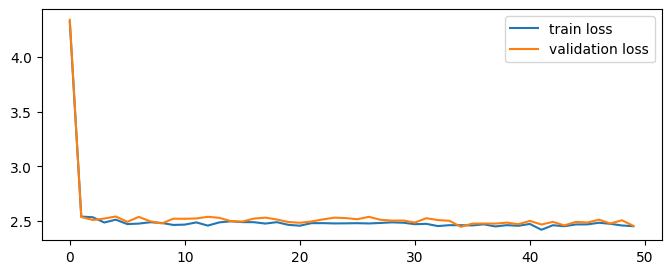

In [425]:
fig, ax_l = plt.subplots(1, 1, figsize=(8,3))
ax_l.plot(np.array(loss_history["train"]).flatten(), label = 'train loss')
ax_l.plot(np.array(loss_history["val"]).flatten(), label = 'validation loss')
ax_l.legend()

In [426]:
print(model2.generate_string(initial_context, max_new_tokens=500))


Thins; s ookesthouk bl,-der, s, es s;
RI th t olk verescee Coun!
Y theee isheresed we hrist ar
ENCELONTherveirake mes ht knt
NG thin.


'd!
Wheseson rwoun. ar?
EEThar IA:
Whthathe couf mhir, byoass ooung, hathese hawaye hernd end,
My w flouth se ma than:
Her, thof t, o amongllinoulateald weat r theat bef fowalo'dooorrt bur th ho'liower lifl he punilf gur outo theayoourer:
Anowitens y, t y po my,
The,
I LESengr JUS: d busend stho,
JUCUMy pat ingr brifo s men'ed.
Whathee s his ote h henike o 
Maru
